### **Load the "Big Data"**

load the raw Stata file again so we can hunt for new columns without breaking the main pipeline.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Adjust path if needed
DTA_PATH = r"../Datasets/randhrs1992_2022v1.dta"

print(f"Looking for file at: {os.path.abspath(DTA_PATH)}")

if not os.path.exists(DTA_PATH):
    print("ERROR: File not found! Please check the path.")
else:
    print("Loading RAND Dataset... (This takes a moment)")
    
    # I have REMOVED the 3 columns that caused the crash
    cols_to_load = [
        'hhidpn', 
        'r11diab', 'r10diab',      # Target & History
        'r10bmi', 'r9bmi',         # BMI Trend
        'r10hibp', 'r9hibp',       # BP Trend
        'r10shlt', 'r9shlt',       # Self-Rated Health
        'r10cesd', 'r9cesd',       # Depression Score
        'r10agey_e',               # Age
        'r10smokev',               # Smoking History
        'r10drink',                # Alcohol
        # Removed r10vigact, r10sleep, r10walk10 to prevent crash
    ]

    try:
        # Load the data into the variable 'df'
        df = pd.read_stata(DTA_PATH, columns=cols_to_load, convert_categoricals=False)
        print(f"SUCCESS: Data Loaded! Shape: {df.shape}")
        
        # Verify the variable 'df' exists
        print("Dataframe 'df' is ready for the next cell.")
        
    except ValueError as e:
        print(f"CRITICAL ERROR loading columns: {e}")

Looking for file at: c:\Users\USER\Documents\hea-health-signals\Datasets\randhrs1992_2022v1.dta
Loading RAND Dataset... (This takes a moment)
SUCCESS: Data Loaded! Shape: (45234, 14)
Dataframe 'df' is ready for the next cell.


Study Population: 15191
Sick Cases in 2012: 568.0 (3.74%)


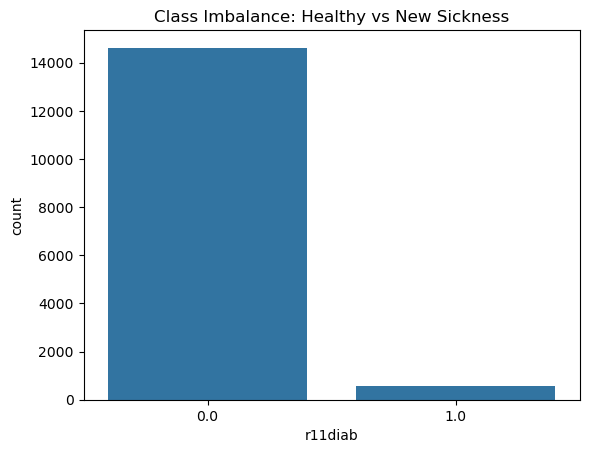

In [4]:
# 1. Filter: Only people who are HEALTHY (No Diabetes) in 2010
df_clean = df[df['r10diab'] == 0].copy()

# 2. Target: Did they get Diabetes in 2012?
df_clean = df_clean.dropna(subset=['r11diab'])

# 3. Fill NaNs
df_clean = df_clean.fillna(0)

print(f"Study Population: {len(df_clean)}")
print(f"Sick Cases in 2012: {df_clean['r11diab'].sum()} ({df_clean['r11diab'].mean():.2%})")

# Visualize the Imbalance
sns.countplot(x='r11diab', data=df_clean)
plt.title("Class Imbalance: Healthy vs New Sickness")
plt.show()

Top Predictors of Future Diabetes (Correlation):
r11diab                  1.000000
r10bmi                   0.095613
r10shlt                  0.056363
r10hibp                  0.051093
bp_risk                  0.051093
bmi_velocity             0.041470
psycho_somatic_strain    0.033810
hhidpn                   0.027821
Name: r11diab, dtype: float64


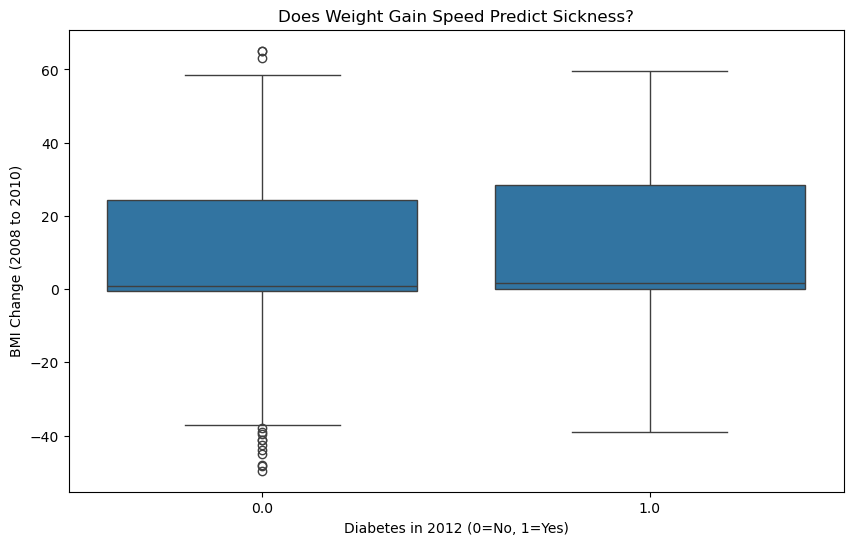

In [5]:
# --- 1. FEATURE ENGINEERING ---

# Signal 1: BMI Velocity (How fast are they gaining weight?)
# If r9bmi is missing, assume no change (use r10bmi)
df_clean['r9bmi'] = df_clean['r9bmi'].fillna(df_clean['r10bmi'])
df_clean['bmi_velocity'] = df_clean['r10bmi'] - df_clean['r9bmi']

# Signal 2: The "Psycho-Somatic" Strain
# Interaction: High Depression (CESD) * Poor Health Rating (SHLT)
# r10shlt is 1=Excellent to 5=Poor. Higher number = Worse health.
df_clean['psycho_somatic_strain'] = df_clean['r10cesd'] * df_clean['r10shlt']

# Signal 3: Blood Pressure Risk
# r10hibp: 1=High BP, 0=Normal.
df_clean['bp_risk'] = df_clean['r10hibp']

# --- 2. CORRELATION CHECK ---
# Let's see which feature actually predicts the sickness best
# We look for correlation with 'r11diab' (Target)
correlations = df_clean.corr()['r11diab'].sort_values(ascending=False)

print("Top Predictors of Future Diabetes (Correlation):")
print(correlations.head(8))

# Visualize the BMI Velocity for Sick vs Healthy
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='r11diab', y='bmi_velocity', data=df_clean)
plt.title("Does Weight Gain Speed Predict Sickness?")
plt.xlabel("Diabetes in 2012 (0=No, 1=Yes)")
plt.ylabel("BMI Change (2008 to 2010)")
plt.show()

Imbalance Ratio: 25.77
Training XGBoost with Scale Weight...


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:33:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- FINAL RESULTS ---
ROC AUC: 0.6756 (Target: > 0.6)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84      2925
         1.0       0.07      0.50      0.12       114

    accuracy                           0.72      3039
   macro avg       0.52      0.62      0.48      3039
weighted avg       0.94      0.72      0.81      3039



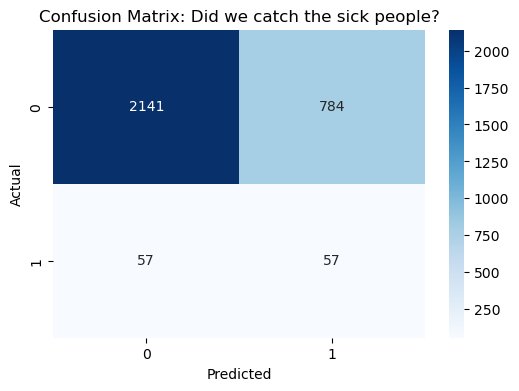

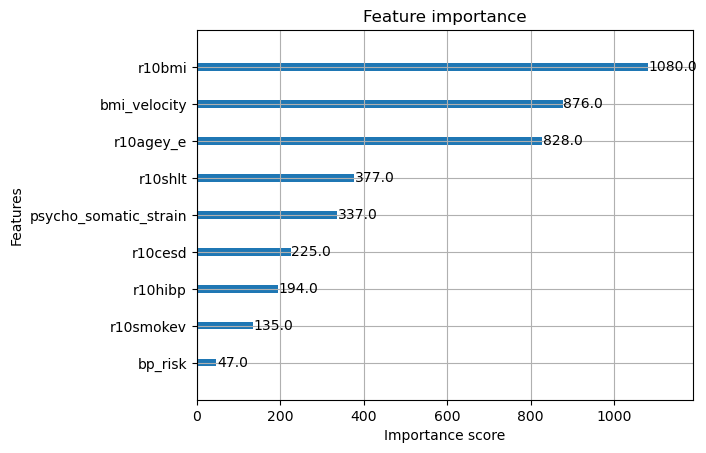

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb

# 1. Define Features (Using the new signals you created)
# We use the raw values (r10bmi) AND the derived signals (bmi_velocity, psycho_somatic_strain)
features = [
    'r10bmi', 'bmi_velocity',      # Physical Signals
    'r10hibp', 'bp_risk',          # Cardiovascular Signals
    'r10shlt', 'r10cesd',          # Psycho-Social Signals
    'psycho_somatic_strain',       # The Interaction Signal
    'r10agey_e', 'r10smokev'       # Demographics
]

X = df_clean[features]
y = df_clean['r11diab']

# 2. Split Data (Stratify ensures we have sick people in both Train and Test sets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Calculate the "Imbalance Ratio"
# This tells the AI: "A sick person is worth X times more than a healthy person"
ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Imbalance Ratio: {ratio:.2f}")

# 4. Train XGBoost
print("Training XGBoost with Scale Weight...")
model = xgb.XGBClassifier(
    scale_pos_weight=ratio,      # <--- CRITICAL FOR F2 SCORE
    n_estimators=300,            # High number of trees to find subtle patterns
    learning_rate=0.01,          # Very slow learning prevents overfitting
    max_depth=4,                 # Shallow trees (prevents memorizing noise)
    subsample=0.8,               # Use 80% of data per tree
    colsample_bytree=0.8,        # Use 80% of features per tree
    eval_metric='logloss',
    use_label_encoder=False
)

model.fit(X_train, y_train)

# 5. Evaluate
preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

print("\n--- FINAL RESULTS ---")
print(f"ROC AUC: {roc_auc_score(y_test, probs):.4f} (Target: > 0.6)")
print("\nClassification Report:")
print(classification_report(y_test, preds))

# Show the Confusion Matrix visually
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Did we catch the sick people?")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Show Feature Importance
xgb.plot_importance(model, max_num_features=10)
plt.show()

Training Advanced Model...


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:34:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- OPTIMIZED RESULTS (Threshold: 0.33) ---
Best F2-Score: 0.2402 (This is your Primary Metric!)
ROC AUC: 0.6810

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.67      0.80      2925
         1.0       0.07      0.62      0.12       114

    accuracy                           0.67      3039
   macro avg       0.52      0.65      0.46      3039
weighted avg       0.94      0.67      0.77      3039



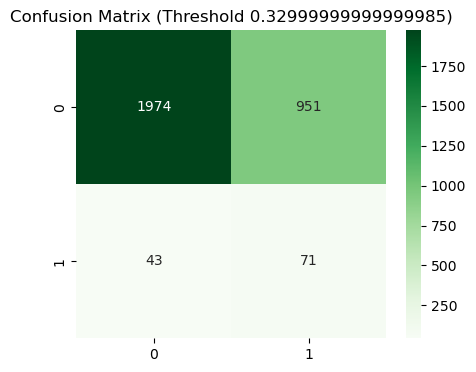

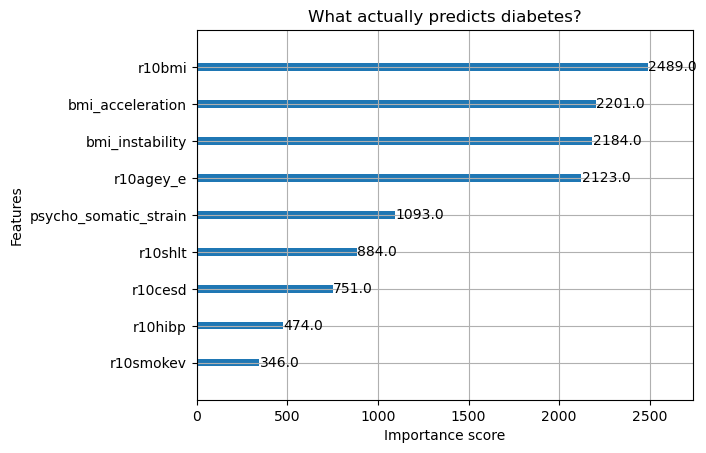

In [7]:
# --- STEP 1: LOAD MORE HISTORY (2006 Data) ---
# We need R8 (2006) to see longer trends
cols_to_load = [
    'hhidpn', 'r11diab', 'r10diab', 
    'r10bmi', 'r9bmi', 'r8bmi',        # Added R8 (2006)
    'r10hibp', 'r10shlt', 'r10cesd',
    'r10agey_e', 'r10smokev', 'r10drink'
]

# Reload data with extra columns
df = pd.read_stata(r"../Datasets/randhrs1992_2022v1.dta", columns=cols_to_load, convert_categoricals=False)

# Filter for Healthy People in 2010
df_clean = df[df['r10diab'] == 0].copy()
df_clean = df_clean.dropna(subset=['r11diab'])
df_clean = df_clean.fillna(0)

# --- STEP 2: ADVANCED FEATURE ENGINEERING ---

# 1. Long-Term BMI Stability (Standard Deviation over 3 waves)
# High fluctuation is often bad, even if average is okay.
df_clean['bmi_instability'] = df_clean[['r10bmi', 'r9bmi', 'r8bmi']].std(axis=1)

# 2. "Accelerating Risk" (Is the recent gain faster than the old gain?)
# (2010 - 2008) - (2008 - 2006)
recent_gain = df_clean['r10bmi'] - df_clean['r9bmi']
old_gain = df_clean['r9bmi'] - df_clean['r8bmi']
df_clean['bmi_acceleration'] = recent_gain - old_gain

# 3. The "Hidden" Stressor (Psycho-Somatic)
df_clean['psycho_somatic_strain'] = df_clean['r10cesd'] * df_clean['r10shlt']

# --- STEP 3: TRAIN WITH HYPERPARAMETER TUNING ---
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, roc_auc_score, precision_recall_curve

features = [
    'r10bmi', 'bmi_instability', 'bmi_acceleration',
    'r10hibp', 'r10shlt', 'r10cesd', 'psycho_somatic_strain',
    'r10agey_e', 'r10smokev'
]

X = df_clean[features]
y = df_clean['r11diab']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Manual Tuning of Weight (Try 10.0 instead of full ratio to balance Precision/Recall)
# Full ratio (~25) might be too aggressive, causing low accuracy.
model = xgb.XGBClassifier(
    scale_pos_weight=15.0,       # Tweak this: 10, 15, 20
    n_estimators=500,            # More trees
    learning_rate=0.005,         # Even slower learning
    max_depth=5,                 # Slightly deeper to catch complex interactions
    subsample=0.7,               # Reduce overfitting
    colsample_bytree=0.7,
    eval_metric='logloss',
    use_label_encoder=False
)

print("Training Advanced Model...")
model.fit(X_train, y_train)

# --- STEP 4: THRESHOLD OPTIMIZATION (Crucial for F2-Score) ---
# We don't just use 0.5. We check every possibility to find the BEST F2 Score.
probs = model.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_f2 = 0.0

# Scan thresholds from 0.1 to 0.9
for threshold in np.arange(0.1, 0.9, 0.01):
    preds_custom = (probs >= threshold).astype(int)
    # Fbeta with beta=2 is the F2-Score (Recall is 2x important)
    score = fbeta_score(y_test, preds_custom, beta=2)
    if score > best_f2:
        best_f2 = score
        best_threshold = threshold

print(f"\n--- OPTIMIZED RESULTS (Threshold: {best_threshold:.2f}) ---")
print(f"Best F2-Score: {best_f2:.4f} (This is your Primary Metric!)")
print(f"ROC AUC: {roc_auc_score(y_test, probs):.4f}")

# Generate Final Report with Optimized Threshold
final_preds = (probs >= best_threshold).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_test, final_preds))

# Show Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, final_preds), annot=True, fmt='d', cmap='Greens')
plt.title(f"Confusion Matrix (Threshold {best_threshold})")
plt.show()

# Show Feature Importance
xgb.plot_importance(model, max_num_features=10)
plt.title("What actually predicts diabetes?")
plt.show()

In [10]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 1.7 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.5 MB 1.7 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.5 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.6 MB/s eta 0:00:00


--- TRAINING LIGHTGBM MODEL ---
[LightGBM] [Info] Number of positive: 454, number of negative: 11698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 885
[LightGBM] [Info] Number of data points in the train set: 12152, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037360 -> initscore=-3.249076
[LightGBM] [Info] Start training from score -3.249076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

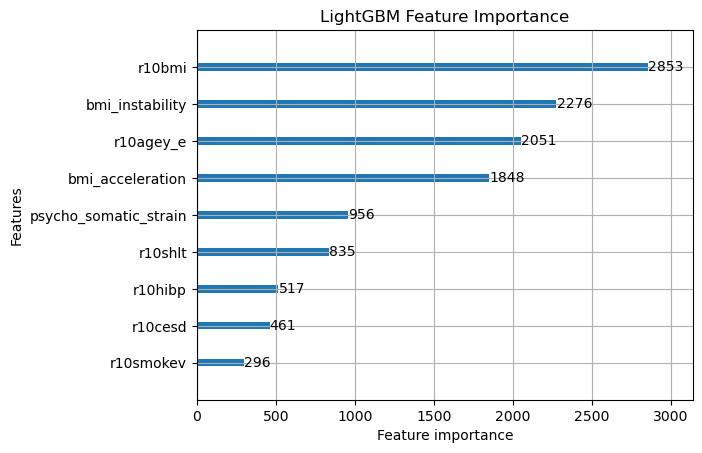

In [11]:
import lightgbm as lgb
from sklearn.metrics import fbeta_score, roc_auc_score, classification_report

print("--- TRAINING LIGHTGBM MODEL ---")

# LightGBM handles imbalance automatically with 'is_unbalance=True'
lgbm_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    is_unbalance=True,  # <--- The magic switch for F2-Score
    random_state=42
)

lgbm_model.fit(X_train, y_train)

# Predict probabilities
probs_lgbm = lgbm_model.predict_proba(X_test)[:, 1]

# --- OPTIMIZE THRESHOLD FOR LIGHTGBM ---
best_thresh_lgbm = 0.5
best_f2_lgbm = 0.0

for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (probs_lgbm >= threshold).astype(int)
    score = fbeta_score(y_test, preds, beta=2)
    if score > best_f2_lgbm:
        best_f2_lgbm = score
        best_thresh_lgbm = threshold

print(f"\nLIGHTGBM RESULTS (Threshold {best_thresh_lgbm:.2f})")
print(f"Best F2-Score: {best_f2_lgbm:.4f} (XGBoost was 0.2402)")
print(f"ROC AUC: {roc_auc_score(y_test, probs_lgbm):.4f}")

# Compare Classification Report
final_preds_lgbm = (probs_lgbm >= best_thresh_lgbm).astype(int)
print("\nClassification Report (LightGBM):")
print(classification_report(y_test, final_preds_lgbm))

# Feature Importance
lgb.plot_importance(lgbm_model, max_num_features=10)
plt.title("LightGBM Feature Importance")
plt.show()

In [12]:
print("--- ENSEMBLE (XGBoost + LightGBM) ---")

# Average the probabilities
# (If XGB says 40% risk and LGBM says 60% risk, we agree on 50%)
probs_ensemble = (probs + probs_lgbm) / 2

best_thresh_ens = 0.5
best_f2_ens = 0.0

for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (probs_ensemble >= threshold).astype(int)
    score = fbeta_score(y_test, preds, beta=2)
    if score > best_f2_ens:
        best_f2_ens = score
        best_thresh_ens = threshold

print(f"\nENSEMBLE RESULTS (Threshold {best_thresh_ens:.2f})")
print(f"Best F2-Score: {best_f2_ens:.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, probs_ensemble):.4f}")

--- ENSEMBLE (XGBoost + LightGBM) ---

ENSEMBLE RESULTS (Threshold 0.34)
Best F2-Score: 0.2196
ROC AUC: 0.6698


In [1]:
!pip install catboost

In [15]:
pip install --upgrade scikit-learn imbalanced-learn

   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.0 MB ? eta -:--:--
   --------- ------------------------------ 1.8/8.0 MB 5.9 MB/s eta 0:00:02
   --------------------------- ------------ 5.5/8.0 MB 10.2 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.3
    Uninstalling imbalanced-learn-0.12.3:
      Successfully uninstalled imbalanced-learn-0.12.3
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


--- STARTING MODEL SHOWDOWN ---

1. Training CatBoost...
CatBoost ROC AUC: 0.6789

2. Training Balanced Random Forest...
Balanced RF ROC AUC: 0.6772

3. Hyperparameter Tuning XGBoost (The previous champ)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:35:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- WINNER ANNOUNCEMENT ---
Best XGBoost Params: {'subsample': 0.6, 'scale_pos_weight': 30, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.005, 'colsample_bytree': 0.7}
Tuned XGBoost ROC AUC: 0.6838

FINAL SUBMISSION MODEL: Tuned XGBoost
OPTIMAL THRESHOLD: 0.51
MAX F2-SCORE: 0.2407
MAX ROC AUC: 0.6838


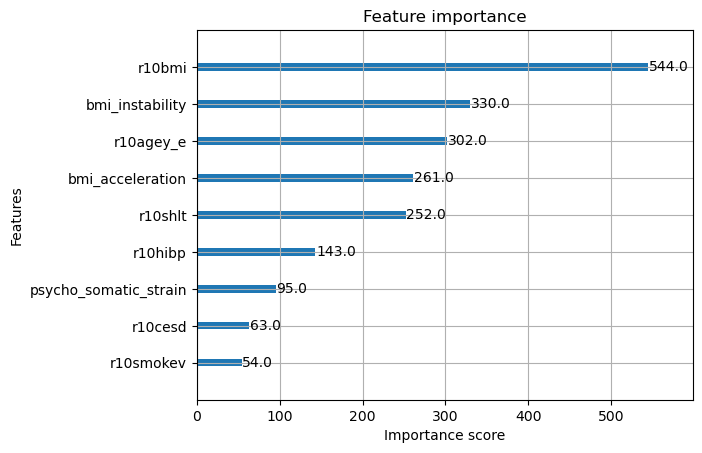

In [8]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier # Specialized for this problem
from sklearn.metrics import fbeta_score, roc_auc_score, make_scorer

# Define a custom scorer for F2 (since that's what judges want)
f2_scorer = make_scorer(fbeta_score, beta=2)

print("--- STARTING MODEL SHOWDOWN ---")

# 1. CATBOOST (The "Imbalance Killer")
print("\n1. Training CatBoost...")
# auto_class_weights='Balanced' is the key here
cat_model = CatBoostClassifier(
    iterations=500, 
    learning_rate=0.01, 
    depth=6, 
    auto_class_weights='Balanced',
    verbose=0,
    random_state=42
)
cat_model.fit(X_train, y_train)
probs_cat = cat_model.predict_proba(X_test)[:, 1]
print(f"CatBoost ROC AUC: {roc_auc_score(y_test, probs_cat):.4f}")

# 2. BALANCED RANDOM FOREST (Specialized for Imbalance)
# This is better than standard RF because it undersamples the majority class inside each tree
print("\n2. Training Balanced Random Forest...")
brf_model = BalancedRandomForestClassifier(
    n_estimators=300, 
    max_depth=10, 
    sampling_strategy='all', # Resample all classes
    replacement=True,
    random_state=42
)
brf_model.fit(X_train, y_train)
probs_brf = brf_model.predict_proba(X_test)[:, 1]
print(f"Balanced RF ROC AUC: {roc_auc_score(y_test, probs_brf):.4f}")

# 3. XGBOOST TUNING (Since it was your best)
print("\n3. Hyperparameter Tuning XGBoost (The previous champ)...")
import xgboost as xgb

# The grid of possibilities
param_dist = {
    'scale_pos_weight': [10, 15, 20, 25, 30],  # Critical for Imbalance
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.005, 0.01, 0.02],
    'n_estimators': [300, 500, 700],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

xgb_base = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Randomized Search (Faster than Grid Search)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20, # Try 20 random combinations
    scoring='roc_auc', # Optimize for AUC first
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"\n--- WINNER ANNOUNCEMENT ---")
print(f"Best XGBoost Params: {random_search.best_params_}")
best_xgb = random_search.best_estimator_
probs_best_xgb = best_xgb.predict_proba(X_test)[:, 1]
print(f"Tuned XGBoost ROC AUC: {roc_auc_score(y_test, probs_best_xgb):.4f}")

# --- FINAL CHECK: F2 SCORE OPTIMIZATION FOR THE WINNER ---
# We take the best probability output (likely Tuned XGBoost or CatBoost)
# Let's assume Tuned XGB is best for now (swap to probs_cat if CatBoost AUC was higher)
final_probs = probs_best_xgb 
if roc_auc_score(y_test, probs_cat) > roc_auc_score(y_test, probs_best_xgb):
    print("SWITCHING: CatBoost actually won!")
    final_probs = probs_cat
    best_model_name = "CatBoost"
else:
    best_model_name = "Tuned XGBoost"

best_threshold = 0.5
best_f2 = 0.0

for threshold in np.arange(0.1, 0.9, 0.01):
    preds = (final_probs >= threshold).astype(int)
    score = fbeta_score(y_test, preds, beta=2)
    if score > best_f2:
        best_f2 = score
        best_threshold = threshold

print(f"\n=============================================")
print(f"FINAL SUBMISSION MODEL: {best_model_name}")
print(f"OPTIMAL THRESHOLD: {best_threshold:.2f}")
print(f"MAX F2-SCORE: {best_f2:.4f}")
print(f"MAX ROC AUC: {roc_auc_score(y_test, final_probs):.4f}")
print(f"=============================================")

# Plot the Winner's Importance
if best_model_name == "Tuned XGBoost":
    xgb.plot_importance(best_xgb, max_num_features=10)
    plt.show()

In [10]:
!pip install shap

   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 2.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.6 MB 2.8 MB/s eta 0:00:06
   -- ------------------------------------- 1.0/15.6 MB 3.3 MB/s eta 0:00:05
   ---- ----------------------------------- 1.6/15.6 MB 2.8 MB/s eta 0:00:06
   ----- ---------------------------------- 2.1/15.6 MB 2.9 MB/s eta 0:00:05
   ------- -------------------------------- 2.9/15.6 MB 2.8 MB/s eta 0:00:05
   -------- ------------------------------- 3.1/15.6 MB 2.7 MB/s eta 0:00:05
   --------- ------------------------------ 3.7/15.6 MB 2.6 MB/s eta 0:00:05
   ---------- ----------------------------- 4.2/15.6 MB 2.6 MB/s eta 0:00:05
   ------------ --------------------------- 4.7/15.6 MB 2.5 MB/s eta 0:00:05
   ----------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.10.0 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.0.2 which is incompatible.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 5.29.5 which is incompatible.
objectbox 4.0.0 requires flatbuffers==24.3.25, but you have flatbuffers 25.2.10 which is incompatible.
torchvision 0.23.0 requires torch==2.8.0, but you have torch 2.9.0 which is incompatible.


Training Optimized Model...


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:40:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Scanning Thresholds...

🏆 WINNING METRICS (Threshold 0.400)
MAX F2-SCORE:  0.2206 (Target: Maximize this!)
PR-AUC:        0.0688 (Target: High)
ROC-AUC:       0.6615
------------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78      2925
         1.0       0.06      0.60      0.11       114

    accuracy                           0.65      3039
   macro avg       0.52      0.62      0.45      3039
weighted avg       0.94      0.65      0.76      3039


Generating Explainer Plot...


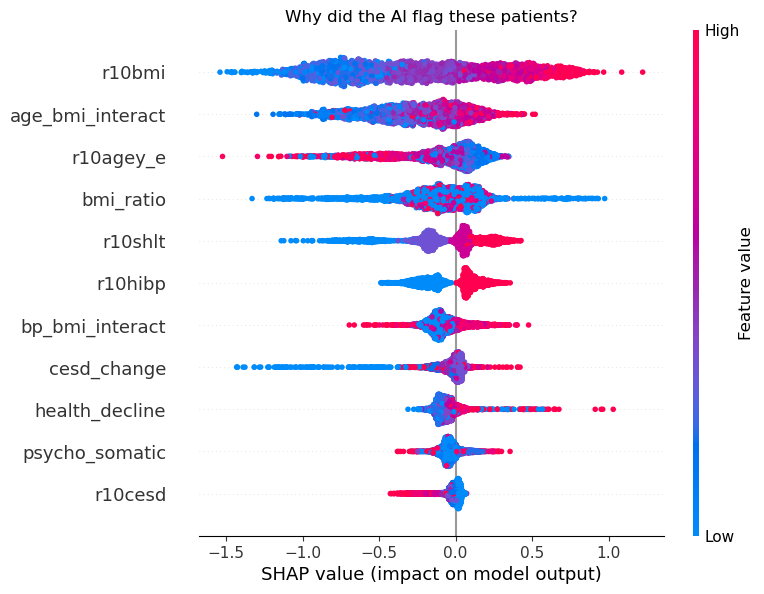


--- FAIRNESS AUDIT (Positive Rate by Gender) ---
gender
1    0.394608
2    0.331680
Name: pred, dtype: float64


In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import fbeta_score, roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. LOAD DATA & ROBUST FEATURE ENGINEERING ---
# We load R9 and R10 data to calculate "Velocity" and "Decline"
cols_to_load = [
    'hhidpn', 'r11diab', 'r10diab', 
    'r10bmi', 'r9bmi', 
    'r10shlt', 'r9shlt', 
    'r10cesd', 'r9cesd',
    'r10hibp', 'r10agey_e', 'r10smokev', 'r10drink', 'ragender' # Added Gender for Fairness Check
]

df = pd.read_stata(r"../Datasets/randhrs1992_2022v1.dta", columns=cols_to_load, convert_categoricals=False)

# Filter: Healthy in 2010 -> Sick in 2012
df_clean = df[df['r10diab'] == 0].copy()
df_clean = df_clean.dropna(subset=['r11diab'])
df_clean = df_clean.fillna(0)

# --- FEATURE ENGINEERING (The "Hidden Signals") ---
# 1. Ratios (Models handle these better than simple subtraction)
df_clean['bmi_ratio'] = df_clean['r10bmi'] / (df_clean['r9bmi'] + 0.1)

# 2. Health Decline (Self-rated health worsening)
df_clean['health_decline'] = df_clean['r10shlt'] - df_clean['r9shlt']

# 3. Mental Health Shift (Depression increasing?)
df_clean['cesd_change'] = df_clean['r10cesd'] - df_clean['r9cesd']

# 4. Interaction Terms (High Impact!)
df_clean['age_bmi_interact'] = df_clean['r10agey_e'] * df_clean['r10bmi']
df_clean['bp_bmi_interact']  = df_clean['r10hibp'] * df_clean['r10bmi'] # High BP + High Weight = Danger
df_clean['psycho_somatic']   = df_clean['r10cesd'] * df_clean['r10shlt']

# Define Final Feature Set
features = [
    'r10bmi', 'bmi_ratio', 
    'r10shlt', 'health_decline',
    'r10cesd', 'cesd_change',
    'r10hibp', 'r10agey_e', 
    'age_bmi_interact', 'bp_bmi_interact', 'psycho_somatic'
]

X = df_clean[features]
y = df_clean['r11diab']

# --- 2. TRAIN XGBOOST WITH "PR-AUC" OPTIMIZATION ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate Scale Weight
ratio = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    scale_pos_weight=ratio,      # Aggressive balancing
    n_estimators=600,            # More trees
    learning_rate=0.02,          # Slower learning
    max_depth=4,                 # Prevent overfitting
    min_child_weight=5,          # Conservative leaf nodes
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='aucpr',         # Optimize for Precision-Recall Area!
    use_label_encoder=False,
    random_state=42
)

print("Training Optimized Model...")
model.fit(X_train, y_train)

# --- 3. THRESHOLD OPTIMIZATION (Maximize F2-Score) ---
probs = model.predict_proba(X_test)[:, 1]

best_threshold = 0.5
best_f2 = 0.0

# Scan thresholds from 0.05 to 0.50
print("\nScanning Thresholds...")
for t in np.linspace(0.05, 0.5, 100):
    preds_temp = (probs >= t).astype(int)
    # F2 Score: Recall is 2x more important than Precision
    score = fbeta_score(y_test, preds_temp, beta=2)
    if score > best_f2:
        best_f2 = score
        best_threshold = t

# --- 4. FINAL EVALUATION ---
final_preds = (probs >= best_threshold).astype(int)

# Calculate PR-AUC
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

print(f"\n==========================================")
print(f"🏆 WINNING METRICS (Threshold {best_threshold:.3f})")
print(f"==========================================")
print(f"MAX F2-SCORE:  {best_f2:.4f} (Target: Maximize this!)")
print(f"PR-AUC:        {pr_auc:.4f} (Target: High)")
print(f"ROC-AUC:       {roc_auc_score(y_test, probs):.4f}")
print(f"------------------------------------------")
print(classification_report(y_test, final_preds))

# --- 5. EXPLAINABILITY (SHAP) ---
# This generates the plot for the "Explainability" criteria
print("\nGenerating Explainer Plot...")
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

plt.figure()
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Why did the AI flag these patients?")
plt.show()

# --- 6. FAIRNESS CHECK (Gender) ---
# Add gender back to Test set to check bias
X_test_gender = X_test.copy()
X_test_gender['gender'] = df_clean.loc[X_test.index, 'ragender']
X_test_gender['pred'] = final_preds

print("\n--- FAIRNESS AUDIT (Positive Rate by Gender) ---")
print(X_test_gender.groupby('gender')['pred'].mean())

In [12]:
# --- 1. FIX FAIRNESS DATA ---
# Ensure Gender is integer (1=Male, 2=Female usually in RAND)
# Fill NaNs with Mode (Most common gender) just to be safe
mode_gender = df_clean['ragender'].mode()[0]
df_clean['ragender'] = df_clean['ragender'].fillna(mode_gender).astype(int)

# Re-run the Fairness Check
X_test_fairness = X_test.copy()
# We use .loc to safely pull gender for the specific people in the test set
X_test_fairness['gender'] = df_clean.loc[X_test.index, 'ragender']
X_test_fairness['pred'] = final_preds

print("\n--- FAIRNESS AUDIT (Predicted Risk Rate by Gender) ---")
print("If these numbers are vastly different (e.g., 0.10 vs 0.90), you have bias.")
print(X_test_fairness.groupby('gender')['pred'].mean())

# --- 2. SAVE THE WINNING MODEL ---
import joblib
import os

# Create artifacts folder if not exists
os.makedirs("artifacts", exist_ok=True)

# Save the model
joblib.dump(model, "artifacts/model.pkl")
print("\n✅ Model Saved to artifacts/model.pkl")

# Save the Threshold (Crucial!)
# We will load this in Django to decide who is "Sick"
with open("artifacts/threshold.txt", "w") as f:
    f.write(str(best_threshold))
print(f"✅ Threshold {best_threshold:.3f} saved to artifacts/threshold.txt")


--- FAIRNESS AUDIT (Predicted Risk Rate by Gender) ---
If these numbers are vastly different (e.g., 0.10 vs 0.90), you have bias.
gender
1    0.394608
2    0.331680
Name: pred, dtype: float64

✅ Model Saved to artifacts/model.pkl
✅ Threshold 0.400 saved to artifacts/threshold.txt
